In [22]:
import os
total_images = 0
base_dir = r"/Users/fatimatuzzahra/Downloads/processed_slices/train"

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.lower().endswith('.png'):
            total_images += 1

print("Total images in testing folder:", total_images)


Total images in testing folder: 84825


In [20]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import torch
import clip
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.ensemble import RandomForestClassifier

In [ ]:
base_dir = r"smart_aug/saved_augmented"
class_names = ['AD', 'CN', 'MCI']
total_images = 0

for class_name in class_names:
    path = os.path.join(base_dir, class_name)
    if os.path.exists(path):
        num_files = len([f for f in os.listdir(path) if f.lower().endswith('.jpg')])
        print(f"{class_name} axial images: {num_files}")
        total_images += num_files
    else:
        print(f" Path not found: {path}")

print("Total axial images:", total_images)


AD axial images: 0
CN axial images: 0
MCI axial images: 0
Total axial images: 0


In [78]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [6]:
import torch, torchvision
print("Torch:", torch.__version__)
print("TorchVision:", torchvision.__version__)

Torch: 2.7.0
TorchVision: 0.22.0


import torch
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
import torchvision.transforms as T
from monai.networks.nets import DenseNet121
from monai.transforms import Compose, LoadImage, Resize, ScaleIntensity, EnsureChannelFirst, ToTensor
from torchvision.models import densenet121, DenseNet121_Weights


# ---- Model ----
weights = DenseNet121_Weights.DEFAULT 
model = densenet121(weights=weights)
full_model = DenseNet121(spatial_dims=2, in_channels=3, out_channels=1, pretrained=True)
feature_extractor = torch.nn.Sequential(*list(full_model.children())[:-1]).to(device)
feature_extractor.eval()

# ---- Transforms ----
class RepeatChannel:
    def __call__(self, img):
        if isinstance(img, np.ndarray):
            img = torch.tensor(img)
        if img.shape[0] == 1:
            return img.repeat(3, 1, 1)
        return img

transform = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    Resize((224, 224)),
    ScaleIntensity(),
    ToTensor(),
    RepeatChannel()
])

augmenter = T.Compose([
    T.Grayscale(num_output_channels=1),
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
    RepeatChannel(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# ---- Paths and Labels ----
base_dir = r"/Users/fatimatuzzahra/Downloads/processed_slices/train"
classes = ['AD', 'CN', 'MCI']
label_map = {cls: idx for idx, cls in enumerate(classes)}

# ---- Mini-batch params ----
BATCH_SIZE = 64

for cls in classes:
    print(f"\nProcessing class: {cls}")
    class_dir = os.path.join(base_dir, cls, 'axial')
    if not os.path.exists(class_dir):
        print(f"Directory not found: {class_dir}")
        continue

    features, labels, image_paths = [], [], []
    file_list = [f for f in os.listdir(class_dir) if f.lower().endswith('.png')]

    for i in tqdm(range(0, len(file_list), BATCH_SIZE), desc=f"Class {cls}"):
        batch_filenames = file_list[i:i + BATCH_SIZE]
        orig_batch, aug_batch = [], []
        batch_paths, batch_labels = [], []

        for fname in batch_filenames:
            img_path = os.path.join(class_dir, fname)
            try:
                # Original
                monai_img = transform(img_path).unsqueeze(0)  # shape: [1, 3, 224, 224]
                orig_batch.append(monai_img)
                batch_labels.append(label_map[cls])
                batch_paths.append(img_path)

                # Augmented
                pil_img = Image.open(img_path).convert("L")
                aug_img = augmenter(pil_img).unsqueeze(0)
                aug_batch.append(aug_img)
                batch_labels.append(label_map[cls])
                batch_paths.append(img_path + "_aug")

            except Exception as e:
                print(f"Failed to process {img_path}: {e}")

        # Stack and send to device
        if orig_batch:
            orig_batch_tensor = torch.cat(orig_batch).to(device)
            aug_batch_tensor = torch.cat(aug_batch).to(device)

            with torch.no_grad():
                orig_feats = feature_extractor(orig_batch_tensor).cpu().numpy()
                aug_feats = feature_extractor(aug_batch_tensor).cpu().numpy()

            all_feats = np.concatenate([orig_feats, aug_feats], axis=0)
            features.extend(all_feats)
            labels.extend(batch_labels)
            image_paths.extend(batch_paths)

    # Save after processing each class
    np.save(f"features_{cls}.npy", np.array(features))
    np.save(f"labels_{cls}.npy", np.array(labels))
    np.save(f"image_paths_{cls}.npy", np.array(image_paths))

    print(f"✅ Saved: features_{cls}.npy | labels_{cls}.npy | image_paths_{cls}.npy")

In [ ]:
from tqdm import tqdm
import os
import numpy as np
import torch
from PIL import Image
from monai.transforms import Compose, LoadImage, Resize, ScaleIntensity, EnsureChannelFirst, ToTensor
from monai.networks.nets import DenseNet121
from torchvision.models import densenet121, DenseNet121_Weights


# --- Feature Extractor ---
full_model = DenseNet121(spatial_dims=2, in_channels=3, out_channels=1, pretrained=True)
feature_extractor = torch.nn.Sequential(*list(full_model.children())[:-1]).to(device)
feature_extractor.eval()

# --- Transforms ---
class RepeatChannel:
    def __call__(self, img):
        if isinstance(img, np.ndarray):
            img = torch.tensor(img)
        if img.shape[0] == 1:
            return img.repeat(3, 1, 1)
        return img

transform = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    Resize((224, 224)),
    ScaleIntensity(),
    ToTensor(),
    RepeatChannel()
])

# --- Paths and Labels ---
base_dir = r"smart_aug/saved_augmented"
classes = ['AD', 'CN', 'MCI']
label_map = {cls: idx for idx, cls in enumerate(classes)}

# --- Batch Size ---
BATCH_SIZE = 64

# --- Processing ---
for cls in classes:
    print(f"\nProcessing class: {cls}")
    class_dir = os.path.join(base_dir, cls)
    if not os.path.exists(class_dir):
        print(f"Directory not found: {class_dir}")
        continue

    features, labels, image_paths = [], [], []
    file_list = [f for f in os.listdir(class_dir) if f.lower().endswith('.jpg')]

    for i in tqdm(range(0, len(file_list), BATCH_SIZE), desc=f"Class {cls}"):
        batch_filenames = file_list[i:i + BATCH_SIZE]
        batch_imgs, batch_labels, batch_paths = [], [], []

        for fname in batch_filenames:
            img_path = os.path.join(class_dir, fname)
            try:
                img = transform(img_path).unsqueeze(0)
                batch_imgs.append(img)
                batch_labels.append(label_map[cls])
                batch_paths.append(img_path)
            except Exception as e:
                print(f"Failed to process {img_path}: {e}")

        if batch_imgs:
            batch_tensor = torch.cat(batch_imgs).to(device)
            with torch.no_grad():
                feats = feature_extractor(batch_tensor).cpu().numpy()

            features.extend(feats)
            labels.extend(batch_labels)
            image_paths.extend(batch_paths)

    # Save per class
    np.save(f"features_{cls}.npy", np.array(features))
    np.save(f"labels_{cls}.npy", np.array(labels))
    np.save(f"image_paths_{cls}.npy", np.array(image_paths))
    print(f" Saved: features_{cls}.npy | labels_{cls}.npy | image_paths_{cls}.npy")


Processing class: AD


Class AD: 100%|██████████| 501/501 [03:21<00:00,  2.48it/s]


✅ Saved: features_AD.npy | labels_AD.npy | image_paths_AD.npy

Processing class: CN


Class CN: 100%|██████████| 501/501 [03:19<00:00,  2.51it/s]


✅ Saved: features_CN.npy | labels_CN.npy | image_paths_CN.npy

Processing class: MCI


Class MCI: 100%|██████████| 501/501 [03:20<00:00,  2.50it/s]


✅ Saved: features_MCI.npy | labels_MCI.npy | image_paths_MCI.npy


In [54]:
features_AD = np.load("features_AD.npy")
features_CN = np.load("features_CN.npy")
features_MCI = np.load("features_MCI.npy")

print(features_AD.shape)
print(features_CN.shape)
print(features_MCI.shape)

# # Flatten: (32029, 1024, 7, 7) → (32029, 1024 * 7 * 7)
features_AD = features_AD.reshape(features_AD.shape[0], -1)
features_CN = features_CN.reshape(features_CN.shape[0], -1)
features_MCI = features_MCI.reshape(features_MCI.shape[0], -1)

(32029, 1024, 7, 7)
(32029, 1024, 7, 7)
(32029, 1024, 7, 7)


In [5]:
import numpy as np


# Labels
labels_AD = np.full(len(features_AD), 0)    # Alzheimer's Disease
labels_CN = np.full(len(features_CN), 1)    # Cognitively Normal
labels_MCI = np.full(len(features_MCI), 2)  # Mild Cognitive Impairment

features_AD = features_AD.astype(np.float16)
features_CN = features_CN.astype(np.float16)
features_MCI = features_MCI.astype(np.float16)

# Concatenate features and labels
all_features = np.concatenate([features_AD, features_CN, features_MCI], axis=0)
all_labels = np.concatenate([labels_AD, labels_CN, labels_MCI], axis=0)

print("All features shape:", all_features.shape)
print("All labels shape:", all_labels.shape)



All features shape: (96087, 50176)
All labels shape: (96087,)


In [ ]:
np.save("train_features_axial_monai.npy", all_features)
np.save("train_labels_axial_monai.npy", all_labels)

print(all_features.shape)
print("Feature vectors saved:")
print("train_features_axial_monai.npy")
print("train_labels_axial_monai.npy")

(96087, 50176)
Feature vectors saved:
train_features_axial_monai.npy
train_labels_axial_monai.npy


same process as above for validation data

In [13]:
import torch
import os
import numpy as np
from tqdm import tqdm
import torchvision.transforms as T
from monai.networks.nets import DenseNet121
from monai.transforms import Compose, LoadImage, Resize, ScaleIntensity, EnsureChannelFirst, ToTensor
from PIL import Image
from torchvision.models import densenet121, DenseNet121_Weights


# Extracting MONAI Image features

weights = DenseNet121_Weights.DEFAULT 
model = densenet121(weights=weights)
full_model = DenseNet121(spatial_dims=2, in_channels=3, out_channels=1, pretrained=True)

# Remove classifier (keep features before final dense layer)
feature_extractor = torch.nn.Sequential(*list(full_model.children())[:-1]).to(device)
feature_extractor.eval()

class RepeatChannel:
    def __call__(self, img):
        if isinstance(img, np.ndarray):
            img = torch.tensor(img)
        if img.shape[0] == 1:
            return img.repeat(3, 1, 1)
        return img

# --- MONAI Transform for original grayscale image ---
transform = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),       # Shape: [1, H, W]
    Resize((224, 224)),
    ScaleIntensity(),
    ToTensor(),
    RepeatChannel()             # Now shape becomes [3, H, W]
])


# --- Paths and Labels ---
base_dir = r"/Users/fatimatuzzahra/Downloads/processed_slices/val"
classes = ['AD', 'CN', 'MCI']
label_map = {cls: idx for idx, cls in enumerate(classes)}

features, labels, image_paths = [], [], []
# --- Batch Size ---
BATCH_SIZE = 64

# --- Processing ---
for cls in classes:
    print(f"\nProcessing class: {cls}")
    class_dir = os.path.join(base_dir, cls, 'axial')
    if not os.path.exists(class_dir):
        print(f"Directory not found: {class_dir}")
        continue

    features, labels, image_paths = [], [], []
    file_list = [f for f in os.listdir(class_dir) if f.lower().endswith('.png')]

    for i in tqdm(range(0, len(file_list), BATCH_SIZE), desc=f"Class {cls}"):
        batch_filenames = file_list[i:i + BATCH_SIZE]
        batch_imgs, batch_labels, batch_paths = [], [], []

        for fname in batch_filenames:
            img_path = os.path.join(class_dir, fname)
            try:
                img = transform(img_path).unsqueeze(0)
                batch_imgs.append(img)
                batch_labels.append(label_map[cls])
                batch_paths.append(img_path)
            except Exception as e:
                print(f"Failed to process {img_path}: {e}")

        if batch_imgs:
            batch_tensor = torch.cat(batch_imgs).to(device)
            with torch.no_grad():
                feats = feature_extractor(batch_tensor).cpu().numpy()

            features.extend(feats)
            labels.extend(batch_labels)
            image_paths.extend(batch_paths)

    # Save per class
    np.save(f"features_{cls}_val.npy", np.array(features))
    np.save(f"labels_{cls}_val.npy", np.array(labels))
    np.save(f"image_paths_{cls}_val.npy", np.array(image_paths))
    print(f" Saved: features_{cls}_val.npy | labels_{cls}.npy | image_paths_{cls}.npy")




Processing class: AD


Class AD: 100%|██████████| 30/30 [00:14<00:00,  2.09it/s]


 Saved: features_AD_val.npy | labels_AD.npy | image_paths_AD.npy

Processing class: CN


Class CN: 100%|██████████| 41/41 [00:15<00:00,  2.62it/s]


 Saved: features_CN_val.npy | labels_CN.npy | image_paths_CN.npy

Processing class: MCI


Class MCI: 100%|██████████| 62/62 [00:24<00:00,  2.58it/s]


 Saved: features_MCI_val.npy | labels_MCI.npy | image_paths_MCI.npy


In [ ]:
import numpy as np
features_AD_val = np.load("features_AD_val.npy")
features_CN_val = np.load("features_CN_val.npy")
features_MCI_val = np.load("features_MCI_val.npy")

print(features_AD_val.shape)
print(features_CN_val.shape)
print(features_MCI_val.shape)

# Flatten: e.g, (32029, 1024, 7, 7) → (32029, 1024 * 7 * 7)
features_AD_val = features_AD_val.reshape(features_AD.shape[0], -1)
features_CN_val = features_CN_val.reshape(features_CN.shape[0], -1)
features_MCI_val = features_MCI_val.reshape(features_MCI.shape[0], -1)

(1870, 1024, 7, 7)
(2585, 1024, 7, 7)
(3960, 1024, 7, 7)


In [19]:
import numpy as np


# Labels
labels_AD = np.full(len(features_AD_val), 0)    # Alzheimer's Disease
labels_CN = np.full(len(features_CN_val), 1)    # Cognitively Normal
labels_MCI = np.full(len(features_MCI_val), 2)  # Mild Cognitive Impairment

features_AD = features_AD.astype(np.float16)
features_CN = features_CN.astype(np.float16)
features_MCI = features_MCI.astype(np.float16)

# Concatenate features and labels
all_features = np.concatenate([features_AD, features_CN, features_MCI], axis=0)
all_labels = np.concatenate([labels_AD, labels_CN, labels_MCI], axis=0)

print("All features shape:", all_features.shape)
print("All labels shape:", all_labels.shape)



All features shape: (8415, 50176)
All labels shape: (8415,)


In [37]:
np.save("val_features_axial_monai.npy", all_features)
np.save("val_labels_axial_monai.npy", all_labels)

print(all_features.shape)
print("Feature vectors saved:")
print("val_features_axial_monai.npy")
print("val_labels_axial_monai.npy")
print(all_labels.shape)

(8415, 50176)
Feature vectors saved:
val_features_axial_monai.npy
val_labels_axial_monai.npy
(8415,)


In [22]:
import numpy as np
import joblib
import gc
from sklearn.ensemble import RandomForestClassifier

# Load data using memory mapping
X_train = np.load("train_features_axial_monai.npy", mmap_mode='r')
y_train = np.load("train_labels_axial_monai.npy")
X_val = np.load("val_features_axial_monai.npy", mmap_mode='r')  # Use mmap for val too if large

# Parameters
n_chunks = 10
chunk_size = X_train.shape[0] // n_chunks
n_estimators = 25
top_k_features = 300

# Initialize importance array
feature_importances = np.zeros(X_train.shape[1])

# Train Random Forests on chunks
for i in range(n_chunks):
    print(f"Processing chunk {i + 1}/{n_chunks}...")
    start = i * chunk_size
    end = (i + 1) * chunk_size if i < n_chunks - 1 else X_train.shape[0]

    # Load chunk into memory
    X_chunk = X_train[start:end].copy()
    y_chunk = y_train[start:end]

    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42 + i, n_jobs=-1)
    rf.fit(X_chunk, y_chunk)

    feature_importances += rf.feature_importances_

    del rf, X_chunk, y_chunk
    gc.collect()

# Average importances
feature_importances /= n_chunks

# Get top feature indices
top_indices = np.argsort(feature_importances)[::-1][:top_k_features]

# Save if needed
# np.save("rf_top300_indices.npy", top_indices)

# Reduce datasets and force load into memory
print("Reducing feature dimensions...")
X_train_reduced = X_train[:, top_indices].copy()
X_val_reduced = X_val[:, top_indices].copy()

# Optionally save for later use
# np.save("X_train_reduced.npy", X_train_reduced)
# np.save("X_val_reduced.npy", X_val_reduced)

print("Done! Shapes:")
print("X_train_reduced:", X_train_reduced.shape)
print("X_val_reduced:", X_val_reduced.shape)

Processing chunk 1/10...
Processing chunk 2/10...
Processing chunk 3/10...
Processing chunk 4/10...
Processing chunk 5/10...
Processing chunk 6/10...
Processing chunk 7/10...
Processing chunk 8/10...
Processing chunk 9/10...
Processing chunk 10/10...
Reducing feature dimensions...
Done! Shapes:
X_train_reduced: (96087, 300)
X_val_reduced: (8415, 300)


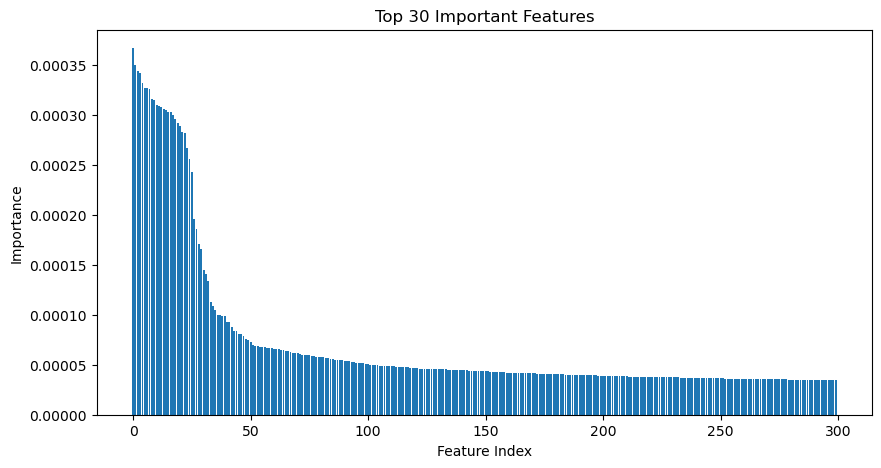

In [38]:
import matplotlib.pyplot as plt  
# # Save reduced datasets
np.save("X_train_reduced_monai.npy", X_train_reduced)
np.save("X_val_reduced_monai.npy", X_val_reduced)

# Save selected feature indices for future use
joblib.dump(top_indices, "selected_rf_indices_monai.pkl")
X_train_reduced = X_train[:, top_indices]
X_test_reduced = X_val[:, top_indices]  # Do the same for test/val sets
plt.figure(figsize=(10, 5))
plt.bar(range(len(top_indices)), feature_importances[top_indices])
plt.title("Top 30 Important Features")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

In [36]:
X_train_reduced = np.load("X_train_reduced_monai.npy")
X_val_reduced = np.load("X_val_reduced_monai.npy")
y_val = np.load("val_labels_axial_monai.npy")

print(X_train.shape)
print(X_val.shape)
print(y_val.shape)

(96087, 300)
(8415, 300)
(8415,)


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


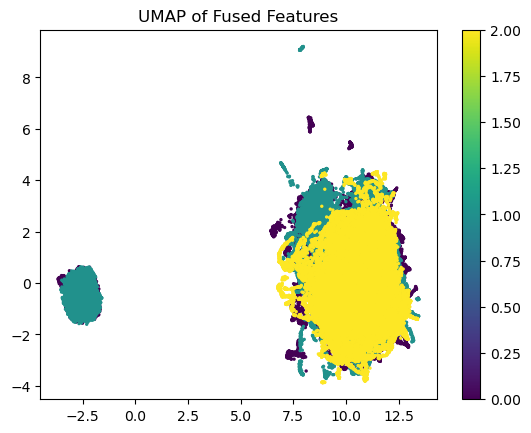

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


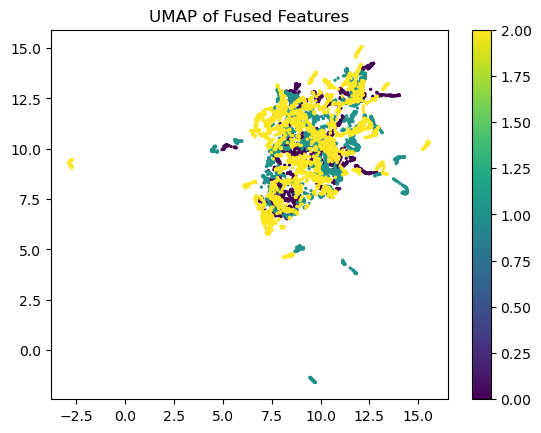

In [37]:
# for visualisation
import umap.umap_ as umap

X_train_reduced = np.load("X_train_reduced_monai.npy")
y_train = np.load("train_labels_axial_monai.npy")
reducer = umap.UMAP(n_components=3, random_state=42)
X_umap_train = reducer.fit_transform(X_train_reduced)

# Visualize 2D UMAP before reducing and balancing
import matplotlib.pyplot as plt
plt.scatter(X_umap_train[:, 0], X_umap_train[:, 1], c=y_train, cmap="viridis", s=2)
plt.title("UMAP of Fused Features")
plt.colorbar()
plt.show()

X_val_reduced = np.load("X_val_reduced_monai.npy")
y_val = np.load("val_labels_axial_monai.npy")
reducer = umap.UMAP(n_components=3, random_state=42)
X_umap_val = reducer.fit_transform(X_val_reduced)

# Visualize 2D UMAP before reducing and balancing
import matplotlib.pyplot as plt
plt.scatter(X_umap_val[:, 0], X_umap_val[:, 1], c=y_val, cmap="viridis", s=2)
plt.title("UMAP of Fused Features")
plt.colorbar()
plt.show()

In [3]:
import numpy as np
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

{0: 32029, 1: 32029, 2: 32029}


In [ ]:
# Undersampled balanced 
# Do it if imbalanced samples
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_balanced, y_balanced = rus.fit_resample(X_train_reduced, y_train)

# Then re-run UMAP
X_umap_bal = reducer.fit_transform(X_balanced)

In [15]:
# Fit on training data
reducer = umap.UMAP(n_components=2, random_state=42, target_metric='categorical')
X_umap_train = reducer.fit_transform(X_balanced, y_balanced)

# Apply to validation data (no fitting here!)
X_umap_val = reducer.transform(X_val)

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [16]:
print(X_balanced.shape)
print(y_balanced.shape)

(96087, 300)
(96087,)


In [ ]:
# Fit on training data with supervision
reducer = umap.UMAP(n_components=2, random_state=42, target_metric='categorical')
X_umap_train = reducer.fit_transform(X_balanced, y_balanced)

# Apply to validation data (no fitting here!)
X_umap_val = reducer.transform(X_val)

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
# Real natural unspervised data
reducer_unsup = umap.UMAP(n_components=2, random_state=42)
X_umap_train_unsup = reducer_unsup.fit_transform(X_balanced)
X_umap_val_unsup = reducer_unsup.transform(X_val)

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


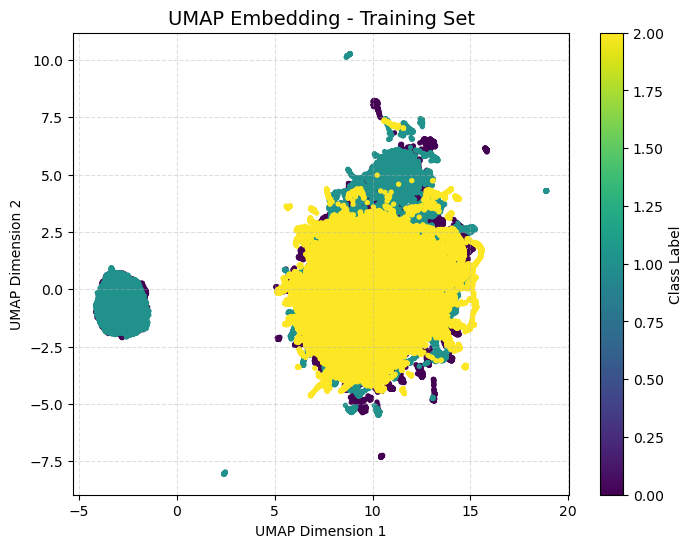

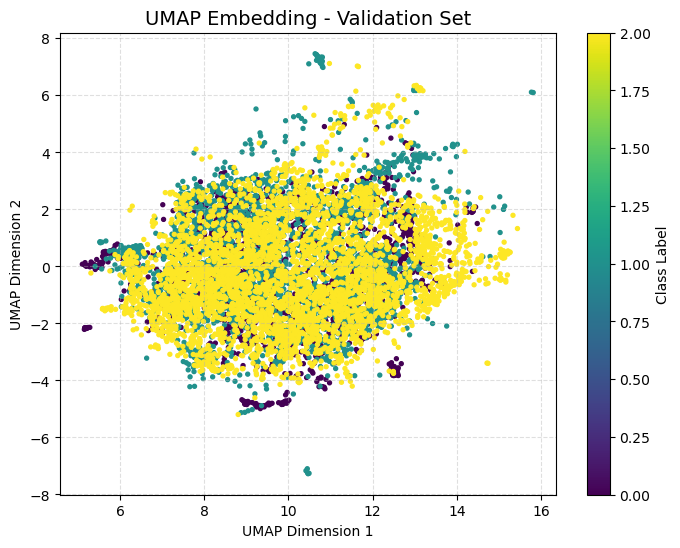

In [33]:
import matplotlib.pyplot as plt

# Plot train set
plt.figure(figsize=(8, 6))
plt.scatter(
    X_umap_train_unsup[:, 0],
    X_umap_train_unsup[:, 1],
    c=y_balanced,
    cmap="viridis",
    s=8
)
plt.title("UMAP Embedding - Training Set", fontsize=14)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.colorbar(label="Class Label")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

# Plot validation set
plt.figure(figsize=(8, 6))
plt.scatter(
    X_umap_val_unsup[:, 0],
    X_umap_val_unsup[:, 1],
    c=y_val,
    cmap="viridis",
    s=8
)
plt.title("UMAP Embedding - Validation Set", fontsize=14)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.colorbar(label="Class Label")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

In [46]:
# Load the .npy files
import pandas as pd
features = np.load("X_train_reduced_monai.npy")       
labels = np.load("train_labels_axial_monai.npy")           

# Combine features and labels
combined = np.hstack((features, labels.reshape(-1, 1)))  

# Create a DataFrame
df = pd.DataFrame(combined)

# Optionally name columns

feature_columns = [f"f{i}" for i in range(features.shape[1])]
df.columns = feature_columns + ["label"]

# Save to CSV
df.to_csv("train_axial_features_and_labels_only_monai.csv", index=False)

print(" Saved: train_axial_features_and_labels_only_monai.csv")


 Saved: train_axial_features_and_labels_only_monai.csv


same process for validation set

In [48]:
# Load the .npy files
features = np.load("X_val_reduced_monai.npy")       # Shape: (84755, 256)
labels = np.load("val_labels_axial_monai.npy")           # Shape: (84755,)


# Combine features and labels
combined = np.hstack((features, labels.reshape(-1, 1)))  # Shape: (84755, 257)

# Create a DataFrame
df = pd.DataFrame(combined)

# Optionally name columns
feature_columns = [f"f{i}" for i in range(features.shape[1])]
df.columns = feature_columns + ["label"]

# Save to CSV
df.to_csv("val_axial_features_and_labels_only_monai.csv", index=False)

print(" Saved: val_axial_features_and_labels_only_monai.csv")


 Saved: val_axial_features_and_labels_only_monai.csv


In [93]:
# for text embeddings
import pandas as pd

# Load your file
df = pd.read_csv("/Users/fatimatuzzahra/Downloads/ADNI1_Merged_AllImages.csv")

# Preview the first few rows
print(df.shape)
df.head()


(2294, 51)


,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,...,AXCRYING,AXELMOOD,AXWANDER,AXFALL,AXOTHER,ID,SITEID,USERDATE,USERDATE2,update_stamp
0,I112538,941_S_1311,MCI,M,70,m12,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,6/1/2008,...,1.0,1.0,1.0,1.0,1.0,4150.0,127.0,5/5/2008,NaN,00:00.0
1,I97341,941_S_1311,MCI,M,70,m06,MRI,MPR-R; GradWarp; B1 Correction; N3; Scaled,Processed,9/27/2007,...,1.0,1.0,1.0,1.0,2.0,2370.0,127.0,9/18/2007,NaN,00:00.0
2,I97327,941_S_1311,MCI,M,69,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,3/2/2007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,I63874,941_S_1202,CN,M,78,sc,MRI,MPR-R; GradWarp; B1 Correction; N3; Scaled,Processed,1/30/2007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,I75150,941_S_1202,CN,M,78,m06,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,8/24/2007,...,1.0,1.0,1.0,2.0,1.0,2110.0,127.0,8/15/2007,NaN,00:00.0


In [94]:
import pandas as pd
import clip
import torch

model, preprocess = clip.load("ViT-B/32", device=device)
# Remove label 
df_cleaned = df.drop(columns=["Group", "Downloaded", "Modality", "Type", "Format"])

# Keep Image ID separately for future mapping
image_ids = df_cleaned["Image Data ID"].values

# Drop ID from the text encoding input
text_only = df_cleaned.drop(columns=["Image Data ID"])

# Convert each row to string and generate sentence embeddings
texts = text_only.astype(str).agg(" ".join, axis=1).tolist()
texts = [t.lower().strip() for t in texts]

# Tokenize all text using CLIP
text_tokens = clip.tokenize(texts, truncate=True).to(device)

# Generate text embeddings
with torch.no_grad():
    text_embeddings = model.encode_text(text_tokens).cpu().numpy()  # shape: (n_samples, 512)
# Save with Image IDs
import numpy as np
np.save("text_embeddings_cleaned.npy", text_embeddings)
np.save("text_image_ids.npy", image_ids)


In [51]:
print("Total samples in df_cleaned:", df_cleaned.shape[0])
print("Unique Image IDs in df_cleaned:", df_cleaned["Image Data ID"].nunique())

Total samples in df_cleaned: 2294
Unique Image IDs in df_cleaned: 2294


In [52]:
import numpy as np
import pandas as pd

# Load the cleaned text embeddings and associated image IDs
text_embeddings = np.load("text_embeddings_cleaned.npy")           # shape: (2294, 384)
text_image_ids = np.load("text_image_ids.npy", allow_pickle=True)  # shape: (2294,)

# Convert to DataFrame and add IDs as the first column
df = pd.DataFrame(text_embeddings)
df.insert(0, "Image_ID", text_image_ids)

# Save to CSV
df.to_csv("text_embeddings_cleaned_with_ids_monai.csv", index=False)

print(" Saved: text_embeddings_cleaned_with_ids_monai.csv")
print(" Shape:", df.shape)


 Saved: text_embeddings_cleaned_with_ids_monai.csv
 Shape: (2294, 513)


In [54]:
image_features = np.load("X_val_reduced_monai.npy")  
print(image_features.shape)

(8415, 300)


In [55]:
import numpy as np
from tqdm import tqdm
import os

# Load image feature data
image_features = np.load("X_train_reduced_monai.npy")      
image_labels = np.load("train_labels_axial_monai.npy")     
image_paths = np.load("train_image_paths_axial.npy")      

# Load cleaned textual embeddings and IDs
textual_embeddings = np.load("text_embeddings_cleaned.npy")   # (2294, 384)
text_ids = np.load("text_image_ids.npy", allow_pickle=True)      # (2294,)

# Step 1: Build a lookup from Image ID → text embedding
text_lookup = {id_: emb for id_, emb in zip(text_ids, textual_embeddings)}

# Step 2: Match each image with its text embedding (based on ID prefix)
fused_features = []
fused_labels = []
matched_count = 0

for i, (img_feat, label, path) in enumerate(tqdm(zip(image_features, image_labels, image_paths), total=len(image_paths))):
    filename = os.path.basename(path)  # e.g., 'I31143_AD_axial_55.png'
    img_id = filename.split('_')[0]             # 'I31143'

    if img_id in text_lookup:
        text_feat = text_lookup[img_id]
        fused = np.concatenate([img_feat, text_feat])  # shape (640,)
        fused_features.append(fused)
        fused_labels.append(label)
        matched_count += 1

print(f" Matched samples: {matched_count}")

# Convert to arrays and save
fused_features = np.array(fused_features)
fused_labels = np.array(fused_labels)

np.save("train_fused_features_clean_monai.npy", fused_features)
np.save("train_fused_labels_clean_monai.npy", fused_labels)

print(" Final train fused shape:", fused_features.shape)
print(" Labels shape:", fused_labels.shape)


 57%|█████▋    | 96087/169650 [00:00<00:00, 328900.92it/s]


 Matched samples: 96087
 Final train fused shape: (96087, 812)
 Labels shape: (96087,)


fusion for the validation set is done below

In [60]:
import numpy as np
from tqdm import tqdm
import os

# Load image feature data
image_features = np.load("X_val_reduced_monai.npy")   # (8415, 30)
image_labels = np.load("val_labels_axial_monai.npy")     
image_paths = np.load("val_image_paths_axial.npy")   


# Load cleaned textual embeddings and IDs
textual_embeddings = np.load("text_embeddings_cleaned.npy")   # (2294, 384)
text_ids = np.load("text_image_ids.npy", allow_pickle=True)      # (2294,)

# Step 1: Build a lookup from Image ID → text embedding
text_lookup = {str(id_).strip(): emb for id_, emb in zip(text_ids, textual_embeddings)}

# Step 2: Match each image with its text embedding (based on ID prefix)
fused_features = []
fused_labels = []
matched_count = 0

default_text_feat = np.zeros(384)


for img_feat, label, path in tqdm(zip(image_features, image_labels, image_paths), total=len(image_paths)):
    img_id = str(os.path.basename(path).split('_')[0]).strip()
    
    if img_id in text_lookup:
        text_feat = text_lookup[img_id]
        matched_count += 1
    else:
        text_feat = default_text_feat
    
    fused = np.concatenate([img_feat, text_feat])
    fused_features.append(fused)
    fused_labels.append(label)

print(f"Matched samples: {matched_count} / {len(image_paths)} ({matched_count / len(image_paths) * 100:.2f}%)")


# Convert to arrays and save
fused_features = np.array(fused_features)
fused_labels = np.array(fused_labels)

np.save("val_fused_features_clean_monai.npy", fused_features)
np.save("val_fused_labels_clean_monai.npy", fused_labels)

print(" Final val fused shape:", fused_features.shape)
print(" Labels shape:", fused_labels.shape)


100%|██████████| 8415/8415 [00:00<00:00, 396391.19it/s]

Matched samples: 8415 / 8415 (100.00%)
 Final val fused shape: (8415, 812)
 Labels shape: (8415,)


In [43]:
import numpy as np

# Load MONAI-extracted features and labels
X_train = np.load("train_fused_features_clean_monai.npy")  # shape: (n_samples, n_features)
y_train = np.load("train_labels_axial_monai.npy")
X_val   = np.load("val_fused_features_clean_monai.npy")
y_val   = np.load("val_labels_axial_monai.npy")

print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)

Train shape: (96087, 812)
Val shape: (8415, 812)


Only to visualise the tetxual data classes weights

Check the textual data variation


Training Set text label distribution:
  Class 0: 469 samples
  Class 1: 319 samples
  Class 2: 753 samples


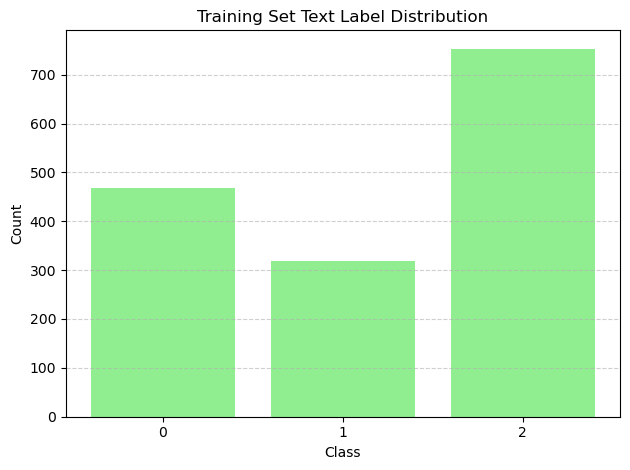


Validation Set text label distribution:
  Class 0: 47 samples
  Class 1: 34 samples
  Class 2: 72 samples


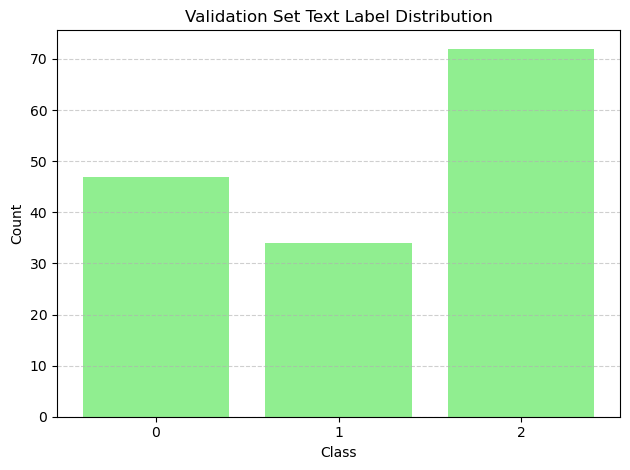

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Load your main metadata DataFrame
df = pd.read_csv("/Users/fatimatuzzahra/Downloads/ADNI1_Merged_AllImages.csv") 

# Optional: convert label names to numeric codes if not already
# Example: {'CN': 0, 'MCI': 1, 'AD': 2}
label_map = {'CN': 0, 'AD': 1, 'MCI': 2}
df["Label"] = df["Group"].map(label_map)  # replace "Group" with actual label column

# Keep the image IDs
image_ids = df["Image Data ID"].values

# Load train/val image path files
train_paths = np.load("train_image_paths_axial.npy")  # contains full paths like '.../I12345_AD_axial_55.png'
val_paths = np.load("val_image_paths_axial.npy")

# Extract image IDs from paths
def extract_ids(paths):
    return set([os.path.basename(p).split('_')[0] for p in paths])

train_ids = extract_ids(train_paths)
val_ids = extract_ids(val_paths)

# Split DataFrame
df_train = df[df["Image Data ID"].isin(train_ids)]
df_val = df[df["Image Data ID"].isin(val_ids)]

# Show counts
def analyze_subset(df_subset, name):
    labels = df_subset["Label"].dropna().astype(int)
    counter = Counter(labels)
    print(f"\n{name} text label distribution:")
    for label, count in sorted(counter.items()):
        print(f"  Class {label}: {count} samples")
    
    # Plot
    plt.bar(counter.keys(), counter.values(), color='lightgreen')
    plt.title(f"{name} Text Label Distribution")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(sorted(counter.keys()))
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Analyze
analyze_subset(df_train, "Training Set")
analyze_subset(df_val, "Validation Set")

In [62]:
print(f"Total images: {len(image_paths)}")
print(f"Unique text IDs: {len(text_ids)}")

# Check overlap
matched = 0
for path in image_paths:
    img_id = os.path.basename(path).split('_')[0]
    if img_id in text_lookup:
        matched += 1

print(f"Image IDs matched with text: {matched}")

Total images: 8415
Unique text IDs: 2294
Image IDs matched with text: 8415


In [ ]:
fused_labels = np.load("val_fused_labels_clean_monai.npy")
unique, counts = np.unique(fused_labels, return_counts=True)
print("Label distribution in fused val set:", dict(zip(unique, counts)))

Label distribution in fused val set: {0: 1870, 1: 2585, 2: 3960}


from tqdm import tqdm
import numpy as np
import os

# Load image feature data
image_features = np.load("X_val_reduced_monai.npy")       # (8415, 256)
image_labels = np.load("val_labels_axial_monai.npy")      # (8415,)
image_paths = np.load("val_image_paths_axial.npy")        # (8415,)

# Load textual embeddings and ID mapping
textual_embeddings = np.load("text_embeddings_cleaned.npy")   # (2294, 384)
text_ids = np.load("text_image_ids.npy", allow_pickle=True)

# Build text embedding lookup
text_lookup = {id_: emb for id_, emb in zip(text_ids, textual_embeddings)}
default_text_feat = np.zeros(384)  # fallback if no text embedding

# Fuse image + text features for all validation samples
fused_features = []
fused_labels = []

for img_feat, label, path in tqdm(zip(image_features, image_labels, image_paths), total=len(image_paths)):
    img_id = os.path.basename(path).split('_')[0]
    text_feat = text_lookup.get(img_id, default_text_feat)
    fused = np.concatenate([img_feat, text_feat])
    fused_features.append(fused)
    fused_labels.append(label)

# Save fused features
fused_features = np.array(fused_features)
fused_labels = np.array(fused_labels)

np.save("val_fused_features_full_monai.npy", fused_features)
np.save("val_fused_labels_full_monai.npy", fused_labels)

# Print confirmation
unique, counts = np.unique(fused_labels, return_counts=True)
print(" Done! Label distribution in full val set:", dict(zip(unique, counts)))

In [68]:
import numpy as np
import pandas as pd

# Load
X = np.load("train_fused_features_clean_monai.npy")
y = np.load("train_fused_labels_clean_monai.npy")

# Combine into DataFrame
df = pd.DataFrame(X)
df["label"] = y

# Save to CSV
df.to_csv("train_fused_embeddings_with_labels_monai.csv", index=False)
print(" Saved: train_fused_embeddings_with_labels_monai.csv")


 Saved: train_fused_embeddings_with_labels_monai.csv


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


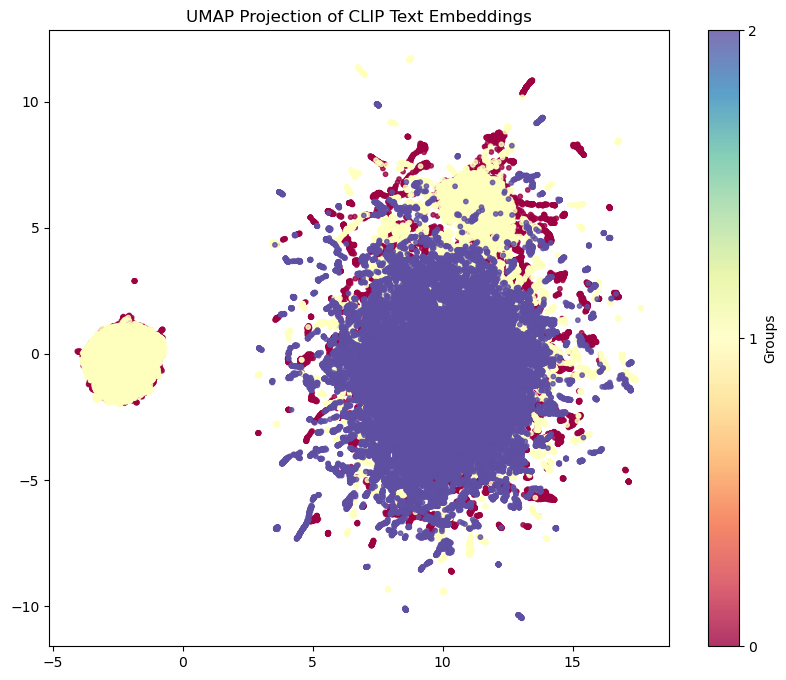

In [100]:
import numpy as np
import umap
import matplotlib.pyplot as plt
import pandas as pd

# Load your saved embeddings and image IDs
fused_embeddings = np.load("train_fused_features_clean_monai.npy")  # shape: (n_samples, 512)

# Optional: load labels if you want to color points by class
# Example: df["Group"] from your original dataframe
labels = np.load("train_fused_labels_clean_monai.npy")              # shape: (n_samples,)

# Create UMAP reducer
reducer = umap.UMAP(n_neighbors=7, min_dist=0.1, metric="cosine", random_state=42)

# Reduce to 2D for visualization
embedding_2d = reducer.fit_transform(fused_embeddings)

# Plot the results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embedding_2d[:, 0], embedding_2d[:, 1],
    c=pd.factorize(labels)[0],  # numeric encoding of labels
    cmap='Spectral', s=10, alpha=0.8
)
plt.colorbar(scatter, ticks=range(len(set(labels))), label="Groups")
plt.title("UMAP Projection of CLIP Text Embeddings")
plt.show()

In [69]:
unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))

{0: 32029, 1: 32029, 2: 32029}


savinf into csv the validation fused sets

In [101]:
import numpy as np
import pandas as pd

# Load
X = np.load("val_fused_features_clean_monai.npy")
y = np.load("val_fused_labels_clean_monai.npy")

# Combine into DataFrame
df = pd.DataFrame(X)
df["label"] = y

# Save to CSV
df.to_csv("val_fused_embeddings_with_labels_monai.csv", index=False)
print(" Saved: val_fused_embeddings_with_labels_monai.csv")


 Saved: val_fused_embeddings_with_labels_monai.csv


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


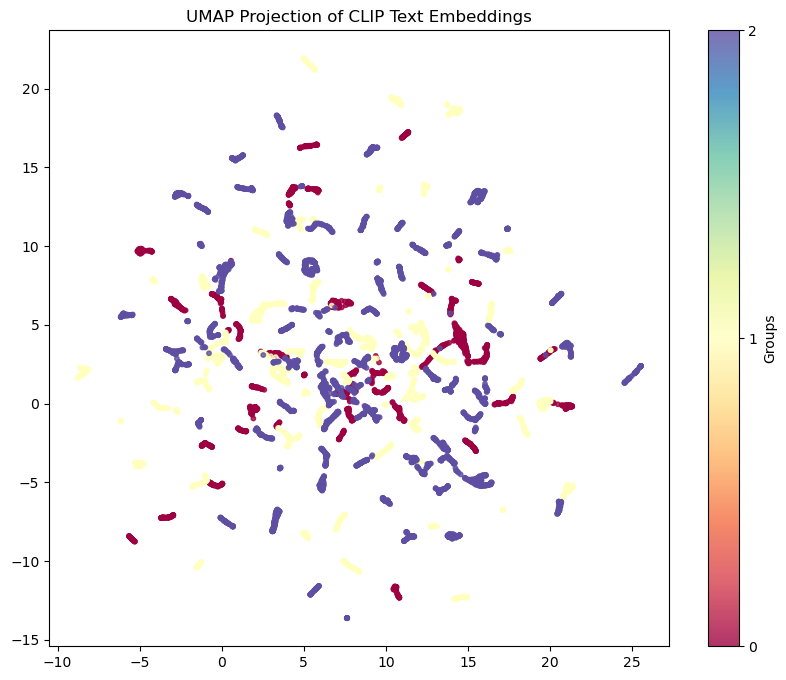

In [103]:
import numpy as np
import umap
import matplotlib.pyplot as plt
import pandas as pd

# Load your saved embeddings and image IDs
fused_embeddings = np.load("val_fused_features_clean_monai.npy")  # shape: (n_samples, 512)

# Optional: load labels if you want to color points by class
# Example: df["Group"] from your original dataframe
labels = np.load("val_fused_labels_clean_monai.npy")              # shape: (n_samples,)

# Create UMAP reducer
reducer = umap.UMAP(n_neighbors=7, min_dist=0.1, metric="cosine", random_state=42)

# Reduce to 2D for visualization
embedding_2d = reducer.fit_transform(fused_embeddings)

# Plot the results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embedding_2d[:, 0], embedding_2d[:, 1],
    c=pd.factorize(labels)[0],  # numeric encoding of labels
    cmap='Spectral', s=10, alpha=0.8
)
plt.colorbar(scatter, ticks=range(len(set(labels))), label="Groups")
plt.title("UMAP Projection of CLIP Text Embeddings")
plt.show()

In [102]:
unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))

{0: 1870, 1: 2585, 2: 3960}


saving image and textual data separately for training dataset

In [ ]:
import numpy as np

# Load fused embeddings
fused = np.load("train_fused_features_clean_monai.npy")  # (96087, 812)

# Split features
image_features = fused[:, :256]   # CNN-based
text_features  = fused[:, 256:]   # CLIP ViT based

# Save separately
np.save("train_image_features_only_monai.npy", image_features)
np.save("train_text_features_only_monai.npy", text_features)

print(" Saved:")
print("  train_image_features_only_monai.npy (shape:", image_features.shape, ")")
print("  train_text_features_only_monai.npy  (shape:", text_features.shape, ")")


 Saved:
  train_image_features_only_monai.npy (shape: (96087, 256) )
  train_text_features_only_monai.npy  (shape: (96087, 556) )


saving image and textual data separately for validation dataset

In [70]:
import numpy as np

# Load fused embeddings
fused = np.load("val_fused_features_clean_monai.npy")  # (84755, 640)

# Split features
image_features = fused[:, :256]   # CNN-based
text_features  = fused[:, 256:]   # Sentence-transformer-based

# Save separately
np.save("val_image_features_only_monai.npy", image_features)
np.save("val_text_features_only_monai.npy", text_features)

print(" Saved:")
print("  val_image_features_only_monai.npy (shape:", image_features.shape, ")")
print("  val_text_features_only_monai.npy  (shape:", text_features.shape, ")")


 Saved:
  val_image_features_only_monai.npy (shape: (8415, 256) )
  val_text_features_only_monai.npy  (shape: (8415, 556) )


In [85]:
import torch.nn as nn

class MLPWithDropout(nn.Module):
    def __init__(self, input_dim):
        super(MLPWithDropout, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),   # input size must match your fused feature size (e.g., 1024 if CLIP image+text)
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 3)       # 3 output classes (AD, CN, MCI)
        )
    def forward(self, x):
        return self.net(x)
input_dim = X_train.shape

Using device: mps
Epoch 1/10 | Train Loss: 0.8400 | Val Loss: 1.0394
Epoch 2/10 | Train Loss: 0.6403 | Val Loss: 1.0842
Epoch 3/10 | Train Loss: 0.5275 | Val Loss: 1.1135
Epoch 4/10 | Train Loss: 0.4517 | Val Loss: 1.1639
Epoch 5/10 | Train Loss: 0.3947 | Val Loss: 1.1829
Epoch 6/10 | Train Loss: 0.3504 | Val Loss: 1.2368
 Early stopping at epoch 6
 Training Accuracy: 0.9122
Training Classification Report:
               precision    recall  f1-score   support

          AD       0.94      0.98      0.96     32029
          CN       0.90      0.85      0.87     32029
         MCI       0.90      0.91      0.90     32029

    accuracy                           0.91     96087
   macro avg       0.91      0.91      0.91     96087
weighted avg       0.91      0.91      0.91     96087

 Validation Accuracy: 0.5743
Validation Classification Report:
               precision    recall  f1-score   support

          AD       0.53      0.65      0.59      1870
          CN       0.50      0.46  

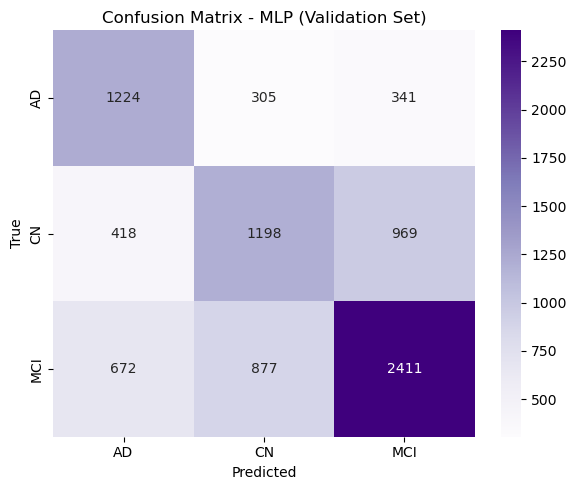

In [87]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# =====================
# Device setup
# =====================
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# =====================
# Define the MLP model
# =====================
# class MLPWithDropout(nn.Module):
#     def __init__(self, input_dim, hidden_dim=256, dropout_rate=0):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Dropout(dropout_rate),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Dropout(dropout_rate),
#             nn.Linear(hidden_dim, 3)  # 3 classes
#         )
#     def forward(self, x):
#         return self.net(x)

# =====================
# Load & preprocess data
# =====================
X_train = np.load("train_fused_features_clean_monai.npy")
y_train = np.load("train_fused_labels_clean_monai.npy")
X_val   = np.load("val_fused_features_clean_monai.npy")
y_val   = np.load("val_fused_labels_clean_monai.npy")

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)

# Handle imbalance with SMOTE
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

# Convert to tensors
X_train_tensor = torch.tensor(X_train_bal, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_bal, dtype=torch.long)
X_val_tensor   = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val, dtype=torch.long)

# Create dataloaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=128, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=128)

# =====================
# Initialize model
# =====================
input_dim = X_train.shape[1]
model = MLPWithDropout(input_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# =====================
# Training with early stopping
# =====================
num_epochs = 10
patience = 5
best_val_loss = float("inf")
epochs_no_improve = 0
train_losses, val_losses = [], []
best_model_state = None

for epoch in range(num_epochs):
    # Train
    model.train()
    total_train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validate
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f" Early stopping at epoch {epoch+1}")
            break

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)

# =====================
# Evaluation function
# =====================
def evaluate(loader, split_name):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            preds = torch.argmax(model(xb), dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.numpy())
    acc = accuracy_score(all_labels, all_preds)
    print(f" {split_name} Accuracy: {acc:.4f}")
    print(f"{split_name} Classification Report:\n", classification_report(all_labels, all_preds, target_names=["AD", "CN", "MCI"]))
    return all_labels, all_preds

# Evaluate
train_labels, train_preds = evaluate(train_loader, "Training")
val_labels, val_preds = evaluate(val_loader, "Validation")

# =====================
# Confusion matrix for validation
# =====================
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=["AD", "CN", "MCI"], yticklabels=["AD", "CN", "MCI"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - MLP (Validation Set)")
plt.tight_layout()
plt.show()

# Cleanup
gc.collect()
torch.mps.empty_cache() if device.type == "mps" else torch.cuda.empty_cache()

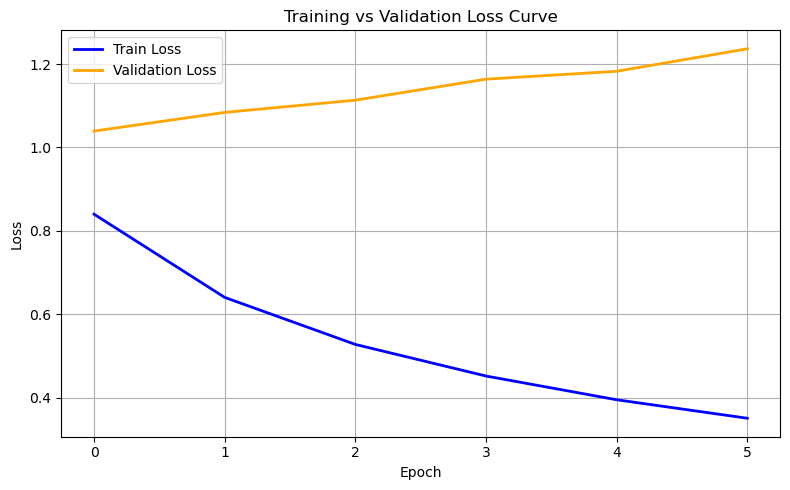

In [88]:
# Loss Curve with Early Stopping Marker
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss', color='blue', linewidth=2)
plt.plot(val_losses, label='Validation Loss', color='orange', linewidth=2)

if early_stop_epoch != -1:
    plt.axvline(early_stop_epoch, color='red', linestyle='--', label=f"Early Stop @ Epoch {early_stop_epoch+1}")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()